In [15]:
# Colab 运行前必跑，安装需要的库
!pip install -q markdownify # requests tqdm
!apt -yqq install fonts-noto-cjk # 安装字体

fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


如果你想要的Tag有很多博文，建议按 月 1/2 博文类型 逐个解析，这样能获取最多的内容，有能力也可以自己写个循环

 ```python
 # 例如：
 标签 = "原神";  筛选年月 = 202503;  博文类型 = "1"
 标签 = "原神";  筛选年月 = 202503;  博文类型 = "2"
 ```

 会检查已下载的图片，如果大小相同会直接跳过

 可以设置的参数：

| 变量名 | 类型 | 介绍 | 示例值 |
|--------|------|------|--------|
| 标签 | string | 搜索的主标签 | `"原神"` |
| 博文类型 | string | `空字符`：全部 `1`：文字 `2`：图片 `4`: 视频 | `0` |
| 筛选年月 | integer | `0`表示不筛选，或使用`YYYYMM`格式 | `202503` |
| **筛选参数** |||
| 白名单 | string | 只要包含其中一个标签就行（逗号或空格分隔） | `"绘图，3D"` |
| 完全白名单 | string | 必须包含所有标签才行（逗号或空格分隔） | `"钟离，温迪"` |
| 黑名单 | string | 包含其中一个标签就不行（逗号或空格分隔） | `"剧透，攻略"` |
| 最低热度 | integer | 低于这个热度的博文将被剔除 | `5000` |
| 文本内容字数限制 | integer | 超过这个字数的博文将被剔除（仅在写入时生效） | `50` |
| **下载参数** |||
| 连接的最大线程数 | integer | 最大线程数（建议4-8） | `4` |
| 是否写文的内容 | boolean | 是否写入文本内容 | `False` |
| 是否写图的内容 | boolean | 是否写入图片内容 | `False` |
| 是否下载图片 | boolean | 是否下载图片 | `False` |


In [ ]:
#!/bin/env python3
#################################################################################
# 这个脚本是一个 Lofter 博客下载器，主要用于下载和解析 Lofter 上的热门标签博文。
# 该脚本支持多线程下载图片，并提供了自定义文件名和筛选器的功能。
#
# 1. 按照 年月-博文类型 解析标签下该月的博文 (最多1000条，服务器端的限制，没有办法绕过)
# 2. 解析完后，获取感兴趣的博文的详情
# 3. 按照要求，按需下载博文的图片和文本内容
#
# 建议使用 Python 3.10 以上版本 （使用了类型注解）
# 需要安装的包 pip install requests  tqdm   markdownify
#                        网络请求  进度条   Markdown 转换
#################################################################################
import os, time, re

输出文件夹 = "."        # . 为当前目录
标签 = "原神" # @param {type:"string"}

# **筛选的年月** `0`：不筛选 或 `YYYYMM` 格式，例如 `202503` 2025年3月
筛选的年月 = 202504 # @param {"type":"integer"}

# **博文类型** `空字符`：全部 `1`：文字 `2`：图片
博文类型 = "" # @param {"type":"string"}

# 下面的设置会影响输出 但不会影响JSON解析 （只有把所有内容下完之后，才能进行筛选）
白名单 = ""      # @param {"type":"string"}
完全白名单 = ""      # @param {"type":"string"}
黑名单 = ""      # @param {"type":"string"}
最低热度  = 5000      # @param {"type":"integer"}
文本内容字数限制 = 0      # @param {"type":"integer"}

# 下载 建议 4-8 线程
连接的最大线程数 = 4      # @param {"type":"integer"}
是否写文的内容 = False      # @param {"type":"boolean"}
是否写图的内容 = False      # @param {"type":"boolean"}
是否下载图片 = False      # @param {"type":"boolean"}

# 解析进度保存的 JSON 文件
backup_list_json_path =  os.path.join(
    输出文件夹,
    f"{标签}_{博文类型}_{筛选的年月}.json.gz" # 保存解析进度到这个json文件
)
""" 这个 JSON 文件是一个字典 存有两个值 data (已解析的内容) 和 offset (当前解析进度)

data 也是一个字典，所包含的键为：
    'post_id':            博文ID
    'type':               博文类型  1: 文本 2: 图片 4: 视频 （目前只处理 1 和 2）
    'blog_id':            用户ID
    'blog_user_name':     用户名 用于访问ta的主页
    'blog_user_nickname': 用户的昵称 （显示的名字）
    'publish_datetime':   博文发出时间  YYYY-MM-DD HH:MM:SS
    'publish_timestamp':  博文发出时间戳 ms 毫秒
    'tag_list':           所有标签 (List)
    'response_count':     回复数
    'favorite_count':     喜欢数
    'share_count':        分享数
    'hot_count':          热度
    'permalink':          暂时存着，将来应该有用
    'title':              博文标题
    'has_detail':         是否有详情 用于判断是否解析过详情
    'content':            博文内容 (解析JSON时为预览内容，并不是完整内容)
    'photo_links':        图片链接 (解析JSON时为空列表) []

如果 offset 为 -1 代表解析完成
"""

# region 自定义
output_folder = 输出文件夹
tag_name = 标签.strip() # 标签名称，去除首尾空格
post_year_month = 筛选的年月
post_types = 博文类型

# 下面的设置会影响输出 但不会影响JSON解析 （只有把所有内容下完之后，才能进行筛选）
white_list = 白名单
white_list = set(item.strip() for item in re.split(r'[,，;； ]+', white_list) if item)
complete_white_list = 完全白名单
complete_white_list = set(item.strip() for item in re.split(r'[,，;； ]+', complete_white_list) if item)
black_list = 黑名单
black_list = set(item.strip() for item in re.split(r'[,，;； ]+', black_list) if item)
min_hot  = 最低热度
text_word_limit = 文本内容字数限制

# 下载设置
max_workers = 连接的最大线程数
is_write_txt = 是否写文的内容
is_write_image_txt = 是否写图的内容
is_download_image = 是否下载图片

# 其他设置/参数
skip_parsed_time = 0.01   # 跳过已解析的时间，单位秒，避免输出过快

# 统计信息相关
n_post_type_skipped = 0   # 博文类型跳过的数量
n_min_host_skipped = 0    # 最小热度跳过的数量
n_complete_white_list_skipped = 0  # 完全白名单跳过的数量
n_white_list_skipped = 0  # 白名单跳过的数量
n_black_list_skipped = 0  # 黑名单跳过的数量

import os, time, json, gzip, re, requests
from pathlib import Path
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import urllib.parse
from markdownify import markdownify
from copy import deepcopy

def custom_file_name(
        post_id, type, blog_id, blog_user_name, blog_user_nickname,
        publish_datetime, publish_timestamp, tag_list, response_count,
        favorite_count, share_count, hot_count, permalink, title,
        has_detail, content, photo_links
    ) -> str:
    """
    自定义输出文件名   发挥主观能动性，并用AI辅助吧！

    可使用的参数可以看上面的注释，注意要使用 safe_name()
    """

    safe_blog_user_nickname = safe_name(blog_user_nickname)
    post_datetime = datetime.fromtimestamp(publish_timestamp / 1000)
    post_time = post_datetime.strftime('%Y%m%d_%H%M')
    year_month = post_datetime.strftime("%Y%m")
    safe_title = safe_name(title) if title else "无标题"

    # 标签/类型/YYYYMM/昵称_时间_类型_热度_标题
    return os.path.join(
        tag_name,
        get_post_types_name(type),
        year_month,
        f"{safe_blog_user_nickname}_{post_time}_{get_post_types_name(type)}_{hot_count}_{safe_title}"
    )

    # 标签/昵称/昵称_时间_类型_热度_标题
    return os.path.join(
        tag_name,
        safe_blog_user_nickname,
        f"{safe_blog_user_nickname}_{post_time}_{get_post_types_name(type)}_{hot_count}_{safe_title}"
    )

    # 这是我的例子： 标签/YYYYMM/昵称_时间_类型_热度_标题
    return os.path.join(
        tag_name,
        year_month,
        f"{safe_blog_user_nickname}_{post_time}_{get_post_types_name(type)}_{hot_count}_{safe_title}"
    )

def custom_stats(backup_list: list[dict]) -> None:
    """
    自定义统计函数，打印并保存一些统计信息

    Args:
        backup_list (List[dict]): 备份列表，包含所有博文的字典列表。
    """

    print("=============================================")
    print(f"[统计] {tag_name} {post_year_month}: 热度 {min_hot} 白名单 {white_list} 黑名单 {black_list} 筛选后")
    print(f"筛选顺序: 博文类型 -> 热度 -> 白名单 -> 完全白名单 -> 黑名单")
    print(f"博文类型跳过: {n_post_type_skipped} 热度跳过: {n_min_host_skipped} 白名单跳过: {n_white_list_skipped} 完全白名单跳过: {n_complete_white_list_skipped} 黑名单跳过: {n_black_list_skipped}")

    n_post_img = n_post_txt = n_post_video = 0

    for backup_dict in backup_list:
        post_type = get_post_types_name(backup_dict['type'])  # "文字" 或 "图片"
        if post_type == "图片":
            n_post_img += 1
        elif post_type == "文字":
            n_post_txt += 1
        elif post_type == "视频":
            n_post_video += 1

    print(f"博文数量: {len(backup_list)} 图:{n_post_img} 文:{n_post_txt} 视频:{n_post_video}")

def custom_filter(
        post_id, type, blog_id, blog_user_name, blog_user_nickname,
        publish_datetime, publish_timestamp, tag_list, response_count,
        favorite_count, share_count, hot_count, permalink, title,
        has_detail, content, photo_links
    ) -> bool:
    """
    自定义的筛选器   发挥主观能动性，并用AI辅助吧！ （只会在生成文本和下载图片时使用，解析JSON时不会生效）

    返回 True 保留该条数据，返回 False 剔除该条数据
    """
    global n_post_type_skipped, n_min_host_skipped, n_white_list_skipped, n_black_list_skipped, n_complete_white_list_skipped

    # 我来举个例子吧：仅在需要时写入
    if is_write_txt or is_write_image_txt or is_download_image:
        if type == 1 and not is_write_txt:
            n_post_type_skipped += 1
            return False
        elif type == 2 and not is_write_image_txt and not is_download_image:
            n_post_type_skipped += 1
            return False

    # 热度大于 你设定的值
    if hot_count < min_hot:
        n_min_host_skipped += 1
        return False  # 跳过该条数据

    # 有想要的标签 在白名单里
    if white_list:
        if (len(set(tag_list).intersection(white_list)) == 0):
            n_white_list_skipped += 1
            return False  # 跳过该条数据

    # 完全白名单
    if complete_white_list:
        if not set(tag_list).issuperset(complete_white_list):
            n_complete_white_list_skipped += 1
            return False  # 跳过该条数据

    # 没有不想要的标签 在黑名单里
    if black_list:
        if (len(set(tag_list).intersection(black_list)) > 0):
            n_black_list_skipped += 1
            return False  # 跳过该条数据

    # 你可以在这里添加更多的筛选条件，比如转发数、评论数等

    return True # 保留该条数据

def custom_filter_for_text(content: str) -> bool:
    """
    自定义的文本筛选器

    Args:
        content (str): 博文的文本内容。

    Returns:
        bool: 是否保留该条数据
    """
    # 移除 YAML front matter (元数据)
    content = re.sub(r'^---\n.*?\n---\n', '', content, flags=re.DOTALL)

    # 移除 Markdown 修饰符
    content = re.sub(r'[#*_\-`~]', '', content)  # 标题、加粗、斜体、列表等标记
    content = re.sub(r'!?\[.*?\]\(.*?\)', '', content)  # 图片和链接
    content = re.sub(r'<!--.*?-->', '', content, flags=re.DOTALL)  # HTML注释

    # 移除多余的空格和空行
    content = re.sub(r'\s+', ' ', content).strip()

    # 统计字符数
    return len(content) >= text_word_limit

def custom_content_process(
        post_id, type, blog_id, blog_user_name, blog_user_nickname,
        publish_datetime, publish_timestamp, tag_list, response_count,
        favorite_count, share_count, hot_count, permalink, title,
        has_detail, content, photo_links
    ) -> str:
    """
    自定义 HTML 内容处理，你可以使用 BS4 之类的库做进一步处理

    我这里是 将博客 HTML 内容转换为 Markdown 格式，并移除多余的格式符号。

    Args:
        content (str): 博客的 HTML 格式正文内容。

    Returns:
        str: 处理后的内容
    """

    content = markdownify(content).replace("****", "") # 转成makrdown而不是纯文本，用于保留链接、格式等信息，避免结构丢失
    tag_lines = "\n  - " + "\n  - ".join(tag_list) if tag_list else "null"
    photo_lines = "\n  - " + "\n  - ".join(photo_links) if photo_links else "null"

    return f"""---
博文id: {post_id}
博文类型：{get_post_types_name(type)}
用户id: {blog_id}
用户名: {blog_user_name}
用户昵称: {blog_user_nickname}
发布时间: "{publish_datetime}"
标签:{tag_lines}
热度: {hot_count}
图片链接:{photo_lines}
---

# {title}

{content}
"""
# endregion

# region 关键代码
HOT_TAG_API_URL = "https://api.lofter.com/newapi/tagPosts.json"
POST_DETIAL_API_URL = "https://api.lofter.com/oldapi/post/detail.api"

def main():
    try:
        backup_list = parse_posts_json()

        if not backup_list:
            print("[解析异常] 未检测到任何博客，请检查设置的 名称 或 时间 或 博文类型")
            return

        if is_write_txt or is_write_image_txt or is_download_image:

            print(f"[获取详细博文] 白名单: {white_list}, 黑名单: {black_list}, 热度: {min_hot}")
            # backup_list = fetch_missing_details(backup_list, max_workers=max_workers) # 获取全部缺失博文详情
            backup_list = fetch_details_if_pass_filter(backup_list, max_workers=max_workers) # 获取筛选后的博文详情
            global parsed_year_month
            save_list_offset_to_json(backup_list, -1, backup_list_json_path) # 保存解析进度到JSON文件

            backup_list = list(filter(lambda x: custom_filter(**x), backup_list)) # 过滤掉不需要的博文

            global n_post_type_skipped, n_min_host_skipped, n_white_list_skipped, n_black_list_skipped, n_complete_white_list_skipped
            n_post_type_skipped //= 2  # 筛了两遍所以除以2
            n_min_host_skipped //= 2
            n_white_list_skipped //= 2
            n_black_list_skipped //= 2
            n_complete_white_list_skipped //= 2

            image_download_list = []  # List[Tuple[str, str]]
            print(f"[写入文本中] {tag_name} ...")

            for backup_dict in backup_list:

                global output_folder
                file_name = os.path.join(output_folder, custom_file_name(**backup_dict))

                # 写入文本内容
                content_path = file_name + ".txt"
                if backup_dict['type'] == 1 and is_write_txt:
                    write_content(backup_dict, content_path)
                elif backup_dict['type'] == 2 and is_write_image_txt:
                    write_content(backup_dict, content_path)

                if is_download_image: # 下载图片
                    for idx, url in enumerate(backup_dict['photo_links']):
                        filename = f"{file_name}_{idx + 1}" + get_file_extension_from_url(url)
                        image_download_list.append((url, filename))

            # 下载图片并显示进度条
            print(f"[下载图片] {tag_name}: 图片数量: {len(image_download_list)}")
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                futures = {
                    executor.submit(download_image, url, output_path): (url, output_path)
                    for url, output_path in image_download_list
                }

                for future in tqdm(as_completed(futures), total=len(futures), desc="下载图片"):
                    url, output_path = futures[future]
                    try:
                        success = future.result()
                        if not success:
                            print(f"下载失败: {url}")
                    except Exception as e:
                        print(f"下载异常: {url} -> {e}")
        else:
            # 没有要写入的，但还是要筛选
            backup_list = list(filter(lambda x: custom_filter(**x), backup_list))

        custom_stats(backup_list)  # 自定义统计信息
    except KeyboardInterrupt:
        print("\n用户中断（Ctrl+C），正在安全退出...")

def parse_posts_json():
    """
    像服务器请求相关内容

    Returns:
        List 包含了所有博文的一个列表
    """

    n_post_img = n_post_txt = 0
    global tag_name, post_types, post_year_month, backup_list_json_path

    # 继续之前中断的下载
    backup_list, offset = load_list_offset_from_json(backup_list_json_path)
    username_blogid_postid_set = set(get_username_blogid_postid_from_backup_dict(backup_dict) for backup_dict in backup_list)
    for backup_dict in backup_list:
        if backup_dict["type"] == 1:
            n_post_txt += 1
        elif backup_dict["type"] == 2:
            n_post_img += 1

    if offset == -1 and len(backup_list) != 0:
        print(f"[跳过JSON下载与解析] 标签: {tag_name}, 图片:{n_post_img}, 文字:{n_post_txt}")
        return backup_list

    # region 解析 JSON
    try:
        start_time = time.time()
        print("开始下载与解析JSON，按 Ctrl+C 终止...")
        print(f"标签: {tag_name}, 博客类型: {get_post_types_name(post_types)}, 搜索年月: {post_year_month}")
        session = requests.Session()
        while True:
            print(f"\r[解析中] {tag_name}: {post_year_month} {get_post_types_name(post_types)}, 偏移：{offset} 图:{n_post_img}, 文:{n_post_txt}, 运行时间: {format_elapsed_time(time.time() - start_time)}", end="", flush=True)

            response = session.post(
                url = HOT_TAG_API_URL,
                headers = get_headers(),
                data = get_hot_tag_payload(
                    tag = tag_name,
                    offset = offset,
                    post_types = post_types,
                    post_year_month = post_year_month
                )
            )

            response_json = response.json()

            if response_json["msg"] != "成功":
                raise ValueError("请求结果不成功")

            for info_dict in response_json['data']['list']:
                backup_dict = get_backup_dict_from_info_dict(info_dict)
                if not backup_dict:
                    raise ValueError

                username_blogid_postid = get_username_blogid_postid_from_backup_dict(backup_dict)

                if username_blogid_postid not in username_blogid_postid_set:
                    backup_list.append(backup_dict)

                    if backup_dict["type"] == 1:
                        n_post_txt += 1
                    elif backup_dict["type"] == 2:
                        n_post_img += 1

            if response_json['data']['offset'] == -1:
                offset = -1
                break

            # 保存到列表后 更新 offset
            offset = response_json['data']['offset']

    except KeyboardInterrupt:
        print(f"\n[解析中断] 检测到 Ctrl+C，正在保存数据...\n标签: {tag_name}, 博客类型: {post_types}, 搜索年月: {post_year_month}, offset: {offset}")
        raise # 继续向上抛出异常

    except (ConnectionError, TimeoutError, requests.ReadTimeout) as e:
        if isinstance(e, ConnectionError):
            errorType = "连接失败"
        elif isinstance(e, TimeoutError):
            errorType = "连接超时"
        else:
            errorType = "读取超时"

        print(f"\n[{errorType}] 标签: {tag_name}, 博客类型: {post_types}, 搜索年月: {post_year_month}, offset: {offset}")

    except ValueError:
        print(f"\n[请求错误] 标签: {tag_name}, 博客类型: {post_types}, 搜索年月: {post_year_month}, offset: {offset}")

    finally:
        if backup_list:
            save_list_offset_to_json(backup_list, offset, backup_list_json_path)
            print(f"\n[解析完成] 数据保存完毕 {backup_list_json_path}")
    # endregion

    return(backup_list)

# region 方法-请求
def format_elapsed_time(seconds: float) -> str:
    """
    将运行时间（秒）格式化为 "HH:MM:SS" 字符串。

    Args:
        seconds (float): 运行时间的总秒数。

    Returns:
        str: 格式化后的字符串，格式为 "小时:分钟:秒"，例如 "01:23:45"。
    """
    total_seconds = int(seconds)
    h = total_seconds // 3600
    m = (total_seconds % 3600) // 60
    s = total_seconds % 60
    return f"{h:02}:{m:02}:{s:02}"

def get_post_types_name(post_types: str) -> str:
    """
    根据博文类型代码返回对应名称。

    Args:
        post_types (str): 博文类型代码，"1" 表示文字，"2" 表示图片，"4" 表示视频，其他或空为所有。

    Returns:
        str: 博文类型名称。
    """
    type_map = {
        "1": "文字",
        "2": "图片",
        "4": "视频",
    }

    return type_map.get(str(post_types), "所有")

def fix_image_url(url: str) -> str:
    """
    如果url包含 nos.netease.com，提取其中 imglf\\d+ 部分，
    并对URL做自定义替换或拼接。

    例子：
        输入:
            http://nos.netease.com/imglf5/img/4fc1c0791abd2d38/...
        输出:
            https://imglf5.lf127.net/img/4fc1c0791abd2d38/...
    """

    if "nos.netease.com" in url:
        start_idx = url.find("imglf")
        if start_idx == -1:
            return url

        end_idx = url.find("/", start_idx)
        if end_idx == -1:
            return url

        imglf_part = url[start_idx:end_idx]

        img_path_idx = url.find("img/", end_idx)
        if img_path_idx == -1:
            return url

        path_part = url[img_path_idx + len("img/"):]
        fixed_url = f"https://{imglf_part}.lf127.net/img/{path_part}"
        return fixed_url

    return url

def get_username_blogid_postid_from_backup_dict(backup_dict: dict) -> str:
    """
    提取用户名、博客ID和博文ID，格式为 username_blogid_postid。

    Args:
        backup_dict (dict): 包含博文信息的备份字典。

    Returns:
        str: 组合后的字符串，如 username_123456_987654321。
    """

    return f"{backup_dict['blog_user_name']}_{backup_dict['blog_id']}_{backup_dict['post_id']}"

def get_file_extension_from_url(url: str) -> str:
    """
    从一个 URL 提取文件扩展名（如 .jpg、.png）

    参数:
        url (str): 包含文件路径的 URL 字符串

    返回:
        str: 文件扩展名（包含点号），如果没有则返回空字符串
    """
    path = urllib.parse.urlparse(url).path
    return Path(path).suffix

def get_headers() -> dict:
    """
    获取请求所需的 HTTP 头部。

    Returns:
        dict: 包含请求头字段的字典。
    """
    return {
        "Accept": '*/*',
        "Accept-Encoding": "gzip",
        "Accept-Language": "zh-CN,zh;q=0.9",
        "Connection": "keep-alive",
        "Content-Type": "application/x-www-form-urlencoded; charset=utf-8",
        "User-Agent": "User-Agent: LOFTER-Android 8.1.28 (V2309A; Android 9; null) WIFI"
    }

def get_hot_tag_payload(tag: str, offset:int = 0, post_types = "", post_year_month: int = 0) -> dict:
    """
    构建请求标签列表接口的 POST 数据负载。

    Args:
        tag (str): 标签名称。
        offset (int, optional): 请求偏移量，默认从0开始，-1表示无内容。
        post_types (str, optional): 文章类型过滤，空字符串代表全部，"1"代表文字，"2"代表图片。
        post_year_month (int, optional): 搜索的年月，格式为 YYYYMM，如 202504，默认为0表示不过滤。

    Returns:
        dict: 用于 POST 请求的参数字典。
    """
    return {
        "product": "lofter-android-8.1.28",
        "postTypes": post_types, # 空：全部 1：文字 2：图片
        "offset": offset,
        "postYm": post_year_month if post_year_month != 0 else "",
        "returnGiftCombination": "",
        "recentDay": 0,
        "protectedFlag": 0,
        "range": 0,
        "firstpermalink": "null",
        "style": 0,
        "tag": tag,
        "type": "total", # "total"：全部 "date": 日榜 "week": 周榜 "month": 月榜
    }

def get_post_detail_payload(tag, post_id, blog_id, blog_user_name: str) -> dict:
    """
    构建请求单篇博文详情接口的 POST 数据负载。

    Args:
        tag (str): 标签名称。
        post_id (int): 博文ID。
        blog_id (int): 博主ID。
        blog_user_name (str): 博主用户名，用于构造博客域名。

    Returns:
        dict: 用于 POST 请求的参数字典。
    """
    return {
        "targetblogid": blog_id, # ['postData']['postView']['blogId']
        "supportposttypes": "1,2,3,4,5,6",
        "tagFrom": tag,
        "blogdomain": f"{blog_user_name}.lofter.com", # ['blogInfo']['blogName']
        "offset": "0",
        "requestType": "0",
        "postdigestnew": "1",
        "postid": post_id, # ['postData']['postView']['id']
        "checkpwd": "1",
        "needgetpoststat": "1"
  }

def get_post_detail_from_info_dict(info_dict) -> dict | None:
    """
    根据热标签接口返回的博文信息字典，调用详情接口获取完整博文详情。

    Args:
        info_dict (dict): 由热标签接口返回的数据中某一项，包含博文基础信息。

    Returns:
        dict: 返回包含博文详情的字典，格式如下：
            - type (int): 博文类型，1为文字，2为图片。
            - content (str): 博文内容。
            - photo_links (list): 图片链接列表（如果有）。
        如果请求失败或数据异常，返回 None。
    """
    detail_response = requests.post(
        url = POST_DETIAL_API_URL,
        headers = get_headers(),
        data = get_post_detail_payload(
            tag = tag_name,
            post_id = info_dict['postData']['postView']['id'],
            blog_id = info_dict['postData']['postView']['blogId'],
            blog_user_name = info_dict['blogInfo']['blogName']
        )
    )

    if detail_response.status_code != 200:
        return None

    detail_response_json = detail_response.json()

    # 如果结果里面没有 posts
    posts = detail_response_json.get('response', {}).get('posts', [])
    if not posts:
        return None

    detail_dict = detail_response_json['response']['posts'][0]['post']

    photo_links = []

    # 图片博客
    if detail_dict['type'] == 2:
        try:
            photo_links = [photo['raw'] for photo in json.loads(detail_dict['photoLinks'])]
            photo_links = [fix_image_url(url) for url in photo_links] # fix the old image url
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            photo_links = []

    return {
        "type": detail_dict['type'],
        "content": detail_dict['content'],
        "photo_links": photo_links,
    }

def get_post_detail_from_backup_dict(backup_dict: dict) -> dict | None:
    """
    根据备份字典获取博文详情。

    Args:
        backup_dict (dict): 备份字典，包含博文的基本信息。

    Returns:
        dict: 返回包含博文详情的字典，格式如下：
            - type (int): 博文类型，1为文字，2为图片。
            - content (str): 博文内容。
            - photo_links (list): 图片链接列表（如果有）。
        如果请求失败或数据异常，返回 None。
    """
    detail_response = requests.post(
        url = POST_DETIAL_API_URL,
        headers = get_headers(),
        data = get_post_detail_payload(
            tag = tag_name,
            post_id = backup_dict['post_id'],
            blog_id = backup_dict['blog_id'],
            blog_user_name = backup_dict['blog_user_name']
        )
    )

    if detail_response.status_code != 200:
        return None

    detail_response_json = detail_response.json()

    # 如果结果里面没有 posts
    posts = detail_response_json.get('response', {}).get('posts', [])
    if not posts:
        return None

    detail_dict = detail_response_json['response']['posts'][0]['post']

    photo_links = []

    # 图片博客
    if detail_dict['type'] == 2:
        try:
            photo_links = [photo['raw'] for photo in json.loads(detail_dict['photoLinks'])]
            photo_links = [fix_image_url(url) for url in photo_links] # fix the old image url
        except (json.JSONDecodeError, KeyError, TypeError) as e:
            photo_links = []

    return {
        "type": detail_dict['type'],
        "content": detail_dict['content'],
        "photo_links": photo_links,
    }

def get_backup_dict_from_info_dict(info_dict: dict) -> dict:
    """
    根据从 HOT_TAG_API_URL 获取的 info_dict 构造备份字典，包含博文的基本信息与详情内容。
    若第一次请求详情失败，将重试一次，若仍失败则返回 None。

    Args:
        info_dict (dict): 单条博文信息，来自 HOT_TAG_API_URL 的响应结构，如 response.json()['data']['list'][i]。

    Returns:
        dict or None: 成功时返回备份信息字典，失败返回 None。备份信息包括用户、标题、内容、标签、图片链接等。
    """
    # 获取详情（最多尝试两次） 会显著增加请求时间，所以注释掉了，JSON解析完后再处理
    # detail_dict = get_post_detail_from_info_dict(info_dict)
    # if detail_dict is None:
    #     detail_dict = get_post_detail_from_info_dict(info_dict)
    #     if detail_dict is None:
    #         return None

    try:
        return {
            # 博文ID
            'post_id':            info_dict['postData']['postView']['id'],
            # 博文类型  1：文本 2：图片
            'type':               info_dict['postData']['postView']['type'],
            # 用户ID
            'blog_id':            info_dict['postData']['postView']['blogId'],
            # 用户名 用于访问ta的主页
            'blog_user_name':     info_dict['blogInfo']['blogName'],
            # 用户的昵称 （显示的名字）
            'blog_user_nickname': info_dict['blogInfo']['blogNickName'],
            # 博文发出时间
            'publish_datetime':   datetime.fromtimestamp(info_dict['postData']['postView']['publishTime'] / 1000).strftime("%Y-%m-%d %H:%M:%S"),
            # 博文发出时间戳 ms 毫秒
            'publish_timestamp':  info_dict['postData']['postView']['publishTime'],
            # 所有标签 （是List）
            'tag_list':           info_dict['postData']['postView']['tagList'],
            # 回复数
            'response_count':     info_dict['postData']['postCount']['responseCount'],
            # 喜欢数
            'favorite_count':     info_dict['postData']['postCount']['favoriteCount'],
            # 分享数
            'share_count':        info_dict['postData']['postCount']['shareCount'],
            # 热度
            'hot_count':          info_dict['postData']['postCount']['hotCount'],
            # 暂时存着，将来应该有用
            'permalink':          info_dict['postData']['postView']['permalink'],
            # 博文标题
            'title':              info_dict['postData']['postView']['title'],
            # 是否有详情 用于判断是否解析过详情
            'has_detail':         False,
            # 博文内容 (解析JSON时为预览内容，并不是完整内容)
            'content':            info_dict['postData']['postView']['digest'],
            # 博文图片链接 (解析JSON时为空列表) []
            'photo_links':        [],
        }
    except Exception:
        return None
# endregion

# region 方法-存储
def fetch_details_if_pass_filter(backup_list: list[dict], max_workers: int = 4) -> list[dict]:
    """
    只对通过 custom_filter 的项目，且未获取详情的，执行 get_post_detail_from_backup_dict。
    保留原始顺序与长度，未处理的项目保持不变。

    Args:
        backup_list (List[dict]): 博文列表。
        max_workers (int): 最大并发线程数。

    Returns:
        List[dict]: 返回更新后的列表，长度和顺序与原始列表一致。
    """
    from concurrent.futures import ThreadPoolExecutor, as_completed

# 找出需要抓取详情的项（记录其原始索引）
    detail_tasks = [
        (idx, item) for idx, item in enumerate(backup_list)
        if not item.get("has_detail", False) and custom_filter(**item)
    ]

    print(f"[详情抓取] 需要更新的博文数量: {len(detail_tasks)}")

    updated_list = deepcopy(backup_list)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_index = {
            executor.submit(get_post_detail_from_backup_dict, item): idx
            for idx, item in detail_tasks
        }

        for future in tqdm(as_completed(future_to_index), total=len(future_to_index), desc="获取博文详情"):
            idx = future_to_index[future]
            try:
                detail = future.result()
                if detail:
                    updated_list[idx].update(detail)
                    updated_list[idx]["has_detail"] = True
            except Exception as e:
                print(f"[异常] 第 {idx} 条详情抓取失败: {e}")

    return updated_list

def load_list_offset_from_json(file_path: str) -> tuple[list, int]:
    """
    读取包含 data 和 offset 的 JSON 文件。

    Args:
        file_path (str): JSON 文件路径，可以是普通 JSON 或 gzip 压缩文件（.gz）

    Returns:
        Tuple[List[Any], int]: 返回一个元组，包含数据列表和偏移量。如果读取失败，返回空列表和 offset=0
    """
    if not file_path or not os.path.exists(file_path):
        return [], 0

    try:
        if file_path.endswith('.gz'):
            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                content = json.load(f)
        else:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = json.load(f)

        data = content.get('data', [])
        offset = content.get('offset', 0)
        return data, offset

    except Exception as e:
        print(f"读取 JSON 文件失败: {e}")
        return [], 0

def save_list_offset_to_json(data: list, offset: int, file_path: str) -> bool:
    """
    将对象保存为 JSON 文件。

    Args:
        data (List[Any]): 要保存的数据列表。
        offset (int): 当前的offset
        filename (str): 目标文件名。如果为空则跳过；如果以 .gz 结尾则使用 gzip 压缩。

    Returns:
        bool: 保存成功返回 True，失败或跳过返回 False。
    """
    if not file_path:
        return False

    try:
        if os.path.dirname(file_path):
            os.makedirs(os.path.dirname(file_path), exist_ok=True)

        dict_to_save = {
            "data": data,
            "offset": offset,
        }

        tmp_path = file_path + ".tmp"

        if file_path.endswith('.gz'):
            with gzip.open(tmp_path, 'wt', encoding='utf-8') as f:
                json.dump(dict_to_save, f, ensure_ascii=False, indent=2)
        else:
            with open(tmp_path, 'w', encoding='utf-8') as f:
                json.dump(dict_to_save, f, ensure_ascii=False, indent=2)

        os.replace(tmp_path, file_path)

    except Exception as e:
        print(f"JSON 保存失败: {e}")
        return False

def safe_name(name: str) -> str:
    """
    清理字符串中的非法文件名字符，包括某些不可见 Unicode 字符。

    Args:
        name (str): 原始文件名。

    Returns:
        str: 安全的、可用于保存文件的名称。
    """
    name = re.sub(r'[\\/:*?"<>|\x00-\x1F]', '_', name)
    name = re.sub(r'[\u200b\u200c\u200d\u2060]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

def download_image(url: str, output_path: str, retries: int = 3) -> bool:
    """
    下载图片到指定路径（重试若失败）。若文件已存在且大小相同则跳过下载

    Args:
        url (str): 图片的 URL
        output_path (str): 下载后保存的完整路径
        retries (int): 最大重试次数，默认 3 次

    Returns:
        bool: 下载是否成功或文件已存在且匹配。
    """
    headers = {"User-Agent": "okhttp/3.10.0"}
    if os.path.dirname(output_path):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # 如果文件已存在，尝试对比大小
    if os.path.isfile(output_path):
        try:
            head_resp = requests.head(url, headers=headers, timeout=10)
            if head_resp.status_code == 200:
                remote_size = int(head_resp.headers.get('Content-Length', 0))
                local_size = os.path.getsize(output_path)
                if remote_size == local_size and remote_size != 0:
                    # 文件大小一致，认为文件相同，跳过下载
                    return True
        except Exception:
            # 如果 HEAD 请求失败，继续正常下载
            pass

    for attempt in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            if response.status_code == 200:
                with open(output_path, "wb") as f:
                    f.write(response.content)
                return True
        except Exception as e:
            pass
            # 可根据需要打印日志
            # print(f"[{attempt+1}/{retries}] 下载错误 {url}: {e}")

    return False

def write_content(backup_dict: dict, output_path: str) -> bool:
    """
    将博客内容字段（HTML）转换为 Markdown，并写入指定路径。

    Args:
        backup_dict (dict): 包含博客数据的字典，需包含 'content' 字段。
        path (str): 要写入的目标文件路径。

    Returns:
        bool: 写入成功返回 True，失败返回 False。
    """
    try:
        content = custom_content_process(**backup_dict)

        # 如果内容为空或不符合自定义过滤条件，则跳过写入
        if not custom_filter_for_text(content):
            return False

        if os.path.dirname(output_path):
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

        with open(output_path, "w", encoding="utf-8") as f:
            f.write(content)

        return True

    except Exception as e:
        print(f"写入内容失败: {output_path}")
        return False
# endregion

if __name__ == "__main__":
    main()

# endregion


[跳过JSON下载与解析] 标签: 原神, 图片:862, 文字:82

[统计] 原神 202504: 热度 5000 白名单 set() 黑名单 set() 筛选后
筛选顺序: 热度 -> 白名单 -> 完全白名单 -> 黑名单
热度跳过: 825 白名单跳过: 0 完全白名单跳过: 0 黑名单跳过: 0
博文数量: 185 图:168 文:17


In [19]:
!ls -lh {backup_list_json_path} # 所有博文信息就在这个json 里面哟

-rw-r--r-- 1 root root 226K May 28 01:32 ./原神__202504.json.gz


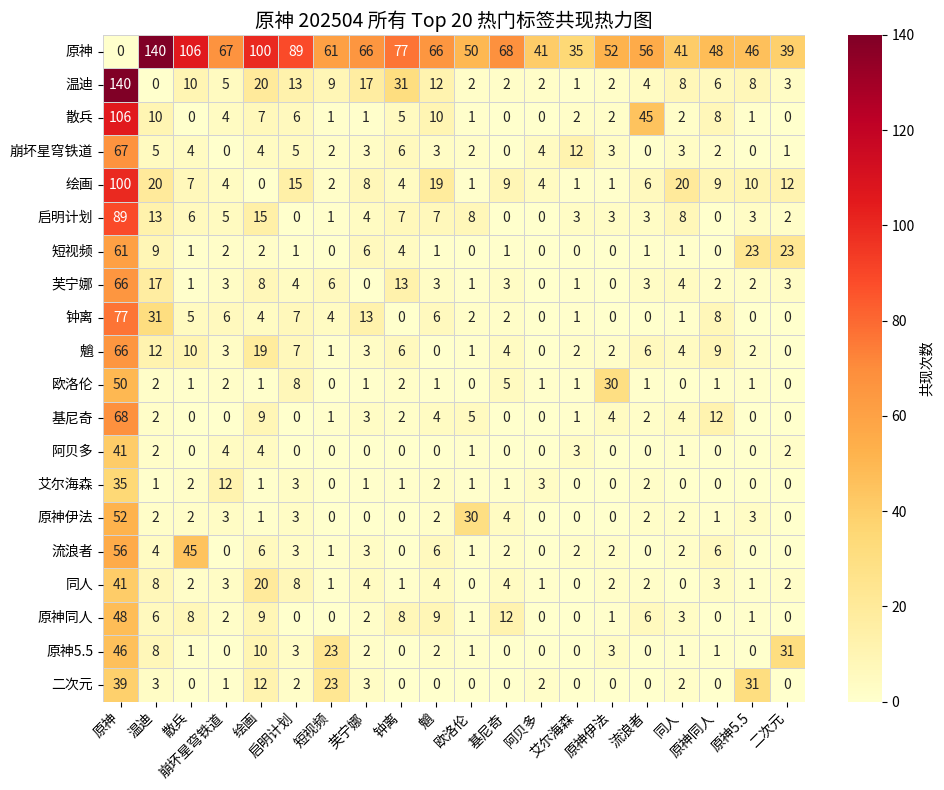

In [18]:
# @markdown # 画热力图

data = json.loads(
    gzip.open(backup_list_json_path, 'rt', encoding='utf-8').read()
)['data']

import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.colors import LogNorm

mpl.font_manager.fontManager.addfont('/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']

tag_heat = defaultdict(int)

for post_info in data:
    for tag in post_info['tag_list']:
        tag_heat[tag] += post_info['hot_count']

# 1. 计算每个标签的总热度
tag_heat = defaultdict(int)
for post_info in data:
    for tag in post_info['tag_list']:
        tag_heat[tag] += post_info['hot_count']


# 2. 选择热度最高的前n个标签
n = 20  # 你可以修改这个值
top_tags = sorted(tag_heat.items(), key=lambda x: -x[1])[:n]
top_tags = [tag for tag, heat in top_tags]  # 提取标签名

# 3. 统计这些标签的共现次数
co_occurrence = defaultdict(int)
for post_info in data:
    # 只考虑前n个标签的共现
    filtered_tags = [tag for tag in post_info['tag_list'] if tag in top_tags]
    for pair in combinations(sorted(filtered_tags), 2):
        co_occurrence[pair] += 1

# 4. 构建共现矩阵
co_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            pair = tuple(sorted([top_tags[i], top_tags[j]]))
            co_matrix[i][j] = co_occurrence.get(pair, 0)

# 5. 转换为DataFrame并绘制热力图
df_co = pd.DataFrame(co_matrix, index=top_tags, columns=top_tags)

plt.figure(figsize=(10, 8))
sns.heatmap(
    df_co,
    cmap='YlOrRd',
    annot=True,
    fmt='g',
    linewidths=0.5,
    linecolor='lightgray',
    # norm=LogNorm(),  # 使用对数颜色
    cbar_kws={'label': '共现次数'}
)
plt.title(f'{tag_name} {post_year_month} {get_post_types_name(post_types)} Top {n} 热门标签共现热力图', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
data = json.loads(
    gzip.open(backup_list_json_path, 'rt', encoding='utf-8').read()
)['data']

# 就是个dict 存放了所有的数据 注意看我的注释
", ".join(sorted(list(data[0].keys())))

'blog_id, blog_user_name, blog_user_nickname, content, favorite_count, has_detail, hot_count, permalink, photo_links, post_id, publish_datetime, publish_timestamp, response_count, share_count, tag_list, title, type'